In [1]:
%pwd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_dir = "Weather"
%matplotlib inline
!mkdir -p $data_dir
!ls $data_dir

data-source.txt		     ghcnd-stations.txt     stations.pkl
ghcnd-readme.txt	     ghcnd-version.txt	    STAT.pickle
ghcnd-stations_buffered.txt  SampleStations.pickle


### Downloading Pickled data from S3
If `SampleStations.pickle` is not in the directory, get it using the following command

In [3]:
#!curl -o $data_dir/SampleStations.pickle http://mas-dse-open.s3.amazonaws.com/Weather/SampleStations.pickle

### Plot Reconstructions

From each measurement, we take 2 sample stations with low residual error and 2 sample stations with high residual error and plot the following:

* Original Data Vector
* Mean Vector
* Reconstructed Data Vector using mean and top 1 eigen vectors
* Reconstructed Data Vector using mean and top 2 eigen vectors
* Reconstructed Data Vector using mean and top 3 eigen vectors

### Read and Preprocess data

Read data from the pickle files `SampleStations.pickle` and `STAT.pickle`

* `SampleStations.pickle` contains information about the 6 measurements taken from some sample stations. You have been provided the code to process this file. It converts the seemingly complicated structure into a list of lists where each sublist has the following information:

`['station','measurement','year','1', '2', '3', ...... , '365']`

*  station - The station ID
*  measurement - One of the 6 types of measurements
*  year - The year in which the measurements were recorded
*  1-365 - The actual value of measurement for each day of the year



* `STAT.pickle` contains statistics about the weather data for each of the 6 measurements and its description.

In [4]:
import pickle
Data=pickle.load(open('Weather/SampleStations.pickle','r'))
STAT,STAT_description=pickle.load(open('Weather/STAT.pickle','r'))

In [5]:
FlatData=[]
for station in Data:
    stationname=station[0]
    for measurements in station[1]:
        measurement,year=measurements[0]
        yeardata=list(measurements[1])
        rowData=[stationname]+[measurement]+[year]+yeardata
        FlatData.append(rowData)

In [6]:
import pandas as pd

frameheader=['station','measurement','year']+range(1,366)
df=pd.DataFrame(FlatData,columns=frameheader)

m_df={}
for m in ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']:
    t_df=df[df['measurement']==m]
    m_df[m]=t_df    

### Define Reconstruction Function

You need to plot reconstructions for two stations with low reconstruction error and two stations with high reconstruction error. To do this, you will need to do the following:

1. Calculate the reconstruction error for the data vector reconstructed using mean and top-3 eigenvectors.
2. Remove the ones for which reconstruction error is NaN.
3. Choose two with the lowest and two with the highest reconstruction error for plotting.

In [7]:
def transmatrix(eigvec,n):
    a=[]
    for i in range(n):
        a.append(eigvec[:,i])
    m=matrix(a)
    return m.T*m

In [30]:
def create_reconstructions(m):  
    
    ## Put your code for computating reconstructions here
    Reconstructed=[[],[],[],[]]
    original=np.matrix(m_df[m].iloc[:,3:])
    Reconstructed[0]=matrix(original)
    Reconstructed[0]=Reconstructed[0]-STAT[m]['Mean']
    for i in range(3):
        TM=transmatrix(STAT[m]["eigvec"],i+1)
        Reconstructed[i+1]=Reconstructed[0]*TM
    
    sortlist=[]
    for i in range(len(Reconstructed[3])):
        sortlist.append([i,np.linalg.norm(Reconstructed[3][i]-Reconstructed[0][i])])
        
    sortlist=[x for x in sortlist if not np.isnan(x[1])]
    sortlist.sort(key=lambda x:x[1])
    lower=[sortlist[0][0],sortlist[1][0]]
    upper=[sortlist[-2][0],sortlist[-1][0]]
    
    for i in range(4):
        Reconstructed[i]=Reconstructed[i]+STAT[m]['Mean']
        Reconstructed[i]=Reconstructed[i].T   
    original = original.tolist()
    yeardays=[i for i in (1,366)]
    plt.figure(figsize=(20,30),dpi=300)
    j=1
    c=0
    for l in lower:
        subplot(4,2,j)
        j+=1
        c+=1
        plot(original[l])
        plot(STAT[m]['Mean'])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (low residual error)')
        xlim([0,365])
        legend(['original','Mean','1','2','3'],loc=2)
    
    c=0
    for l in upper:
        subplot(4,2,j)
        j+=1
        c+=1
        plot(original[l])
        plot(STAT[m]['Mean'])
        plot(Reconstructed[1][:,l])
        plot(Reconstructed[2][:,l])
        plot(Reconstructed[3][:,l])
        title('#' + str(c) + ' Sample for ' + m + ' (high residual error)')
        xlim([0,365])
        legend(['original','Mean','1','2','3'],loc=2)

Reconstruction Plots for TMAX
Reconstruction Plots for SNWD


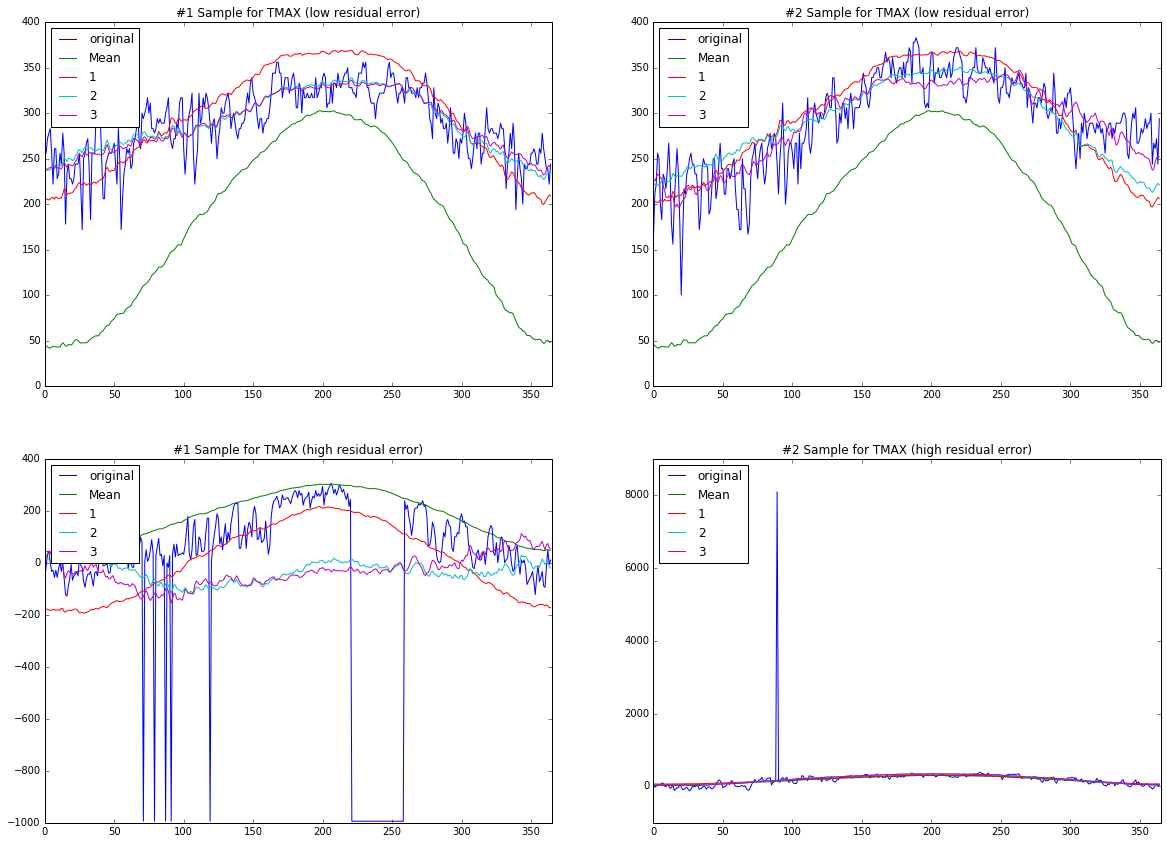

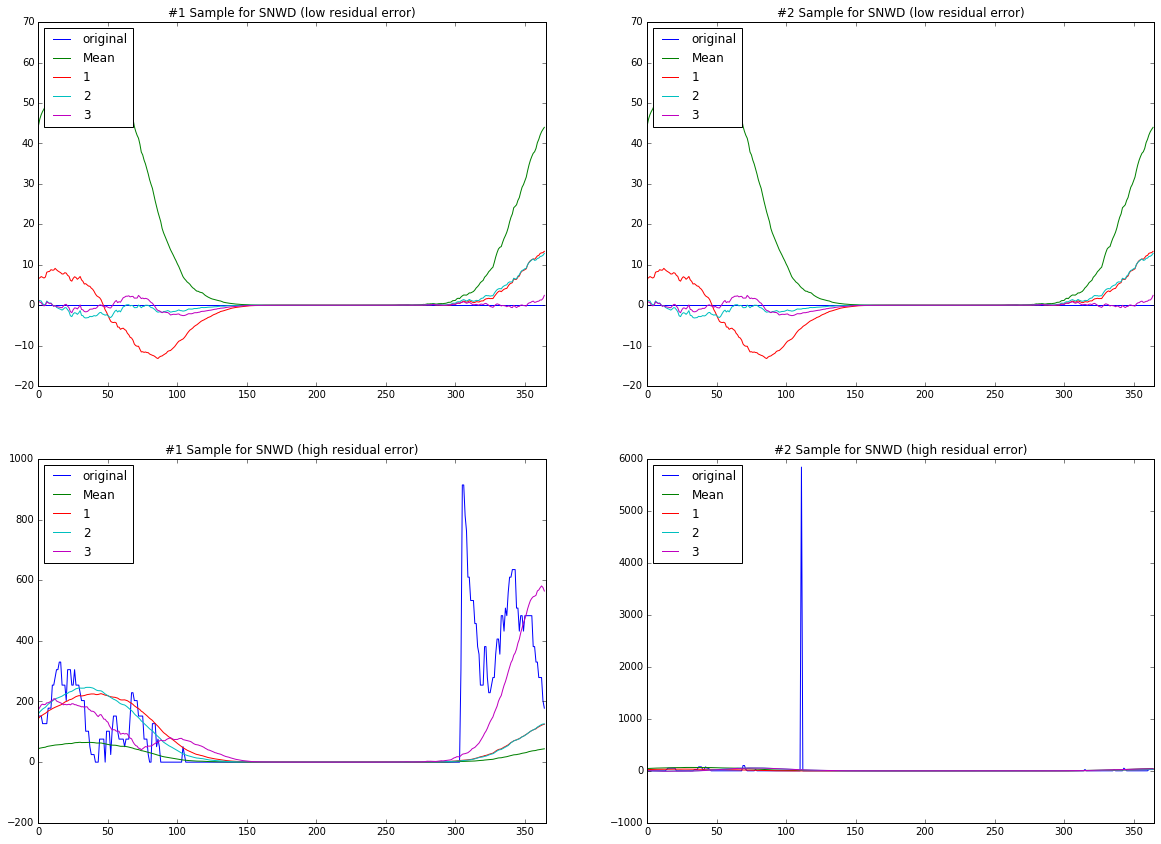

In [31]:
for m in ['TMAX','SNWD']:
    print 'Reconstruction Plots for '+ m
    create_reconstructions(m)